In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import scipy.optimize as opt
from scipy.stats import norm
from tqdm.auto import trange
from tqdm import tqdm
import Metropolis_Algorithm as MA
from scipy.optimize import curve_fit

import importlib

importlib.reload(MA)

import matplotlib as mpl
from scipy.stats import shapiro, kstest, anderson

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

In [36]:
# Setting Constants
x_0 = 0
y_0 = 0
t_i = 0
t_f = 8

mass = 1
steps = 150  # Reduced from 800 - fewer points to update
numb_paths = 1000

times = np.linspace(t_i, t_f, steps)
dt = times[1] - times[0]

In [37]:
# Potential
def x_potential(x):
    return 1 / 2 * x ** 2


def y_potential(x):
    return 1000 * x ** 4


def ho_analytic_pdf(x):
    return (1 / np.sqrt(np.pi)) * np.exp(-x ** 2)


def residual_calculator1(x_values, model, model_parameters, y_values, y_errors):
    theoretical_values = model(x_values, *model_parameters)
    residuals = (y_values - theoretical_values) / y_errors
    return residuals

def residual_calculator2(theoretical_values, y_values, y_errors):
    residuals = (y_values - theoretical_values) / y_errors
    return residuals

# Propagator Data

In [4]:
# Setting Constants

#position boundaries
x_0_prop = 0
x_endpoints_prop = np.linspace(-2, 2, 201)

#time boundaries
t_i_prop = 0
t_f_prop = 6

#other constants
mass_prop = 1
steps_prop = 7
numb_paths_prop = 1000

#array of times
times_prop = np.linspace(t_i_prop, t_f_prop, steps_prop)
dt_prop = times_prop[1] - times_prop[0]
print(x_endpoints_prop)

[-2.   -1.98 -1.96 -1.94 -1.92 -1.9  -1.88 -1.86 -1.84 -1.82 -1.8  -1.78
 -1.76 -1.74 -1.72 -1.7  -1.68 -1.66 -1.64 -1.62 -1.6  -1.58 -1.56 -1.54
 -1.52 -1.5  -1.48 -1.46 -1.44 -1.42 -1.4  -1.38 -1.36 -1.34 -1.32 -1.3
 -1.28 -1.26 -1.24 -1.22 -1.2  -1.18 -1.16 -1.14 -1.12 -1.1  -1.08 -1.06
 -1.04 -1.02 -1.   -0.98 -0.96 -0.94 -0.92 -0.9  -0.88 -0.86 -0.84 -0.82
 -0.8  -0.78 -0.76 -0.74 -0.72 -0.7  -0.68 -0.66 -0.64 -0.62 -0.6  -0.58
 -0.56 -0.54 -0.52 -0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34
 -0.32 -0.3  -0.28 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1
 -0.08 -0.06 -0.04 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14
  0.16  0.18  0.2   0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38
  0.4   0.42  0.44  0.46  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62
  0.64  0.66  0.68  0.7   0.72  0.74  0.76  0.78  0.8   0.82  0.84  0.86
  0.88  0.9   0.92  0.94  0.96  0.98  1.    1.02  1.04  1.06  1.08  1.1
  1.12  1.14  1.16  1.18  1.2   1.22  1.24  1.26  1.28

In [5]:
#Creating the position generating function

def Pos_Gen_prop(x0, xN, Steps, noise_scale=0.3):  #Generates smooth paths with noise
    xs = np.linspace(x0, xN, Steps)
    noise = np.random.normal(0, noise_scale, size=Steps)
    noise[0] = 0.0
    noise[-1] = 0.0
    return xs + noise


#Creating function to evaluate the action integral for a path

def action_harmonic_prop(positions, times, mass):
    #Input Validation
    if type(positions) != np.ndarray:
        raise TypeError("WARNING: position input is not a numpy array")
    if type(times) != np.ndarray:
        raise TypeError("WARNING: time input is not a numpy array")

    #Calculating the action using discrete steps and straight line approx
    S = 0
    for i in range(len(times) - 1):
        dt = times[i + 1] - times[i]
        dx = positions[i + 1] - positions[i]
        T = 0.5 * mass * (dx / dt) ** 2
        V = 0.5 * (((positions[i] + positions[i + 1]) / 2) ** 2)
        S += dt * (T + V)

    return S

[ 0.          0.15981407 -0.87661135 -1.10596523 -1.82375601 -1.04106587
 -2.        ]
201000
201000
[[ 0.         -0.52853085 -0.94061846 -1.01629006 -1.83747596 -1.42048128
  -2.        ]
 [ 0.         -0.33348072 -0.56735761 -0.75770671 -1.4759526  -1.77532019
  -1.98      ]]
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000


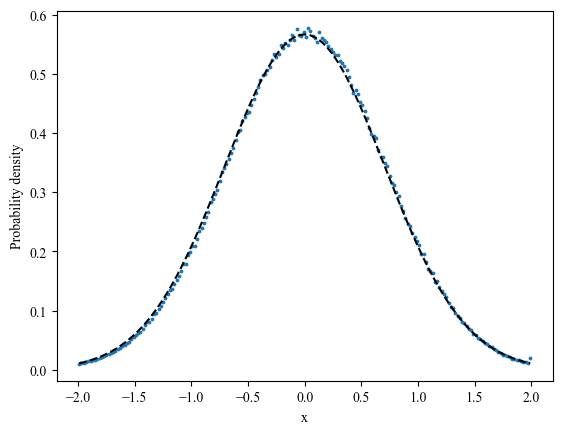

In [6]:
# Generating Paths and calculating weight of each path
paths_prop = []
weights_prop = []
x_end_prop = []

for xN in x_endpoints_prop:
    for _ in range(numb_paths_prop):
        p = Pos_Gen_prop(x_0_prop, xN, steps_prop)
        S = action_harmonic_prop(p, times_prop, mass_prop)
        w = np.exp(-S)
        paths_prop.append(p)
        weights_prop.append(w)
        x_end_prop.append(xN)

paths_prop = np.array(paths_prop)
weights_prop = np.array(weights_prop)
x_end_prop = np.array(x_end_prop)

print(paths_prop[0])
print(len(paths_prop))
print(len(paths_prop))
print(paths_prop[999:1001])

# Finding the groundstate wave function of the path
x_bins_prop = np.linspace(-2, 2, 201)

pdf_unnormalised_prop, bin_edges_prop = np.histogram(x_end_prop, bins=x_bins_prop, weights=weights_prop)
x_centres_prop = 0.5 * (bin_edges_prop[1:] + bin_edges_prop[:-1])
dx_prop = np.diff(x_bins_prop)[0]

# normalize to integrate to 0.5 (since we only use x > 0)
area_prop = np.sum(pdf_unnormalised_prop * dx_prop)
pdf_prop = pdf_unnormalised_prop / (area_prop)

# --- Analytic PDF for comparison (half side only) ---
phi_sq_analytic_prop = (1 / np.sqrt(np.pi)) * np.exp(-x_centres_prop ** 2)
phi_sq_analytic_prop /= np.sum(phi_sq_analytic_prop * dx_prop)  # normalize area to 0.5

# --- Check areas ---
print(f"Numerical PDF area: {np.sum(pdf_prop * dx_prop):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic_prop * dx_prop):.5f}")

plt.figure(1)
plt.scatter(x_centres_prop, pdf_prop, label='Path integral estimate', s=3)
plt.plot(x_centres_prop, phi_sq_analytic_prop, 'k--', label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.show()

In [ ]:
print(len(x_end_prop))

# Metropolis Data

Thermalizing...


Thermalising:  26%|██▌       | 130/500 [00:00<00:00, 697.70it/s]

Endpoint acceptance ≈ 0.515
Endpoint acceptance ≈ 0.506


Thermalising:  66%|██████▌   | 329/500 [00:00<00:00, 623.31it/s]

Endpoint acceptance ≈ 0.550
Endpoint acceptance ≈ 0.501


Thermalising: 100%|██████████| 500/500 [00:00<00:00, 655.01it/s]


Endpoint acceptance ≈ 0.517

Sampling...


Sampling:   1%|          | 28/5000 [00:00<00:07, 686.30it/s]

Endpoint acceptance ≈ 0.527


Sampling:   3%|▎         | 131/5000 [00:00<00:07, 609.00it/s]

Endpoint acceptance ≈ 0.521


Sampling:   4%|▍         | 224/5000 [00:00<00:07, 652.26it/s]

Endpoint acceptance ≈ 0.518


Sampling:   7%|▋         | 327/5000 [00:00<00:07, 631.98it/s]

Endpoint acceptance ≈ 0.548


Sampling:   9%|▊         | 426/5000 [00:00<00:07, 640.70it/s]

Endpoint acceptance ≈ 0.529


Sampling:  11%|█         | 526/5000 [00:00<00:06, 659.85it/s]

Endpoint acceptance ≈ 0.555


Sampling:  13%|█▎        | 632/5000 [00:00<00:06, 670.41it/s]

Endpoint acceptance ≈ 0.534


Sampling:  15%|█▍        | 730/5000 [00:01<00:06, 653.20it/s]

Endpoint acceptance ≈ 0.516


Sampling:  17%|█▋        | 827/5000 [00:01<00:06, 603.45it/s]

Endpoint acceptance ≈ 0.522


Sampling:  19%|█▊        | 926/5000 [00:01<00:06, 661.06it/s]

Endpoint acceptance ≈ 0.555


Sampling:  20%|██        | 1023/5000 [00:01<00:06, 639.23it/s]

Endpoint acceptance ≈ 0.542


Sampling:  23%|██▎       | 1128/5000 [00:01<00:05, 648.45it/s]

Endpoint acceptance ≈ 0.513


Sampling:  25%|██▍       | 1229/5000 [00:01<00:06, 615.80it/s]

Endpoint acceptance ≈ 0.521


Sampling:  26%|██▋       | 1324/5000 [00:02<00:05, 661.75it/s]

Endpoint acceptance ≈ 0.516


Sampling:  29%|██▊       | 1426/5000 [00:02<00:05, 677.92it/s]

Endpoint acceptance ≈ 0.515


Sampling:  30%|███       | 1525/5000 [00:02<00:05, 586.63it/s]

Endpoint acceptance ≈ 0.511


Sampling:  33%|███▎      | 1626/5000 [00:02<00:05, 634.68it/s]

Endpoint acceptance ≈ 0.527


Sampling:  35%|███▍      | 1726/5000 [00:02<00:04, 679.90it/s]

Endpoint acceptance ≈ 0.522


Sampling:  37%|███▋      | 1828/5000 [00:02<00:05, 618.42it/s]

Endpoint acceptance ≈ 0.530


Sampling:  39%|███▊      | 1926/5000 [00:03<00:04, 686.89it/s]

Endpoint acceptance ≈ 0.488


Sampling:  41%|████      | 2026/5000 [00:03<00:04, 599.02it/s]

Endpoint acceptance ≈ 0.509


Sampling:  42%|████▏     | 2122/5000 [00:03<00:05, 567.72it/s]

Endpoint acceptance ≈ 0.537


Sampling:  44%|████▍     | 2217/5000 [00:03<00:05, 548.82it/s]

Endpoint acceptance ≈ 0.523


Sampling:  46%|████▋     | 2315/5000 [00:03<00:04, 624.39it/s]

Endpoint acceptance ≈ 0.520


Sampling:  49%|████▊     | 2428/5000 [00:03<00:03, 649.93it/s]

Endpoint acceptance ≈ 0.532


Sampling:  51%|█████     | 2529/5000 [00:04<00:03, 646.16it/s]

Endpoint acceptance ≈ 0.547


Sampling:  53%|█████▎    | 2628/5000 [00:04<00:03, 652.91it/s]

Endpoint acceptance ≈ 0.524


Sampling:  55%|█████▍    | 2735/5000 [00:04<00:03, 720.53it/s]

Endpoint acceptance ≈ 0.503


Sampling:  57%|█████▋    | 2841/5000 [00:04<00:02, 745.97it/s]

Endpoint acceptance ≈ 0.505


Sampling:  59%|█████▊    | 2937/5000 [00:04<00:02, 727.18it/s]

Endpoint acceptance ≈ 0.541


Sampling:  61%|██████    | 3034/5000 [00:04<00:02, 725.80it/s]

Endpoint acceptance ≈ 0.519


Sampling:  63%|██████▎   | 3134/5000 [00:04<00:02, 668.31it/s]

Endpoint acceptance ≈ 0.505


Sampling:  65%|██████▍   | 3233/5000 [00:05<00:02, 675.33it/s]

Endpoint acceptance ≈ 0.545


Sampling:  67%|██████▋   | 3339/5000 [00:05<00:02, 750.26it/s]

Endpoint acceptance ≈ 0.534


Sampling:  69%|██████▉   | 3438/5000 [00:05<00:02, 727.93it/s]

Endpoint acceptance ≈ 0.520


Sampling:  71%|███████   | 3539/5000 [00:05<00:01, 746.19it/s]

Endpoint acceptance ≈ 0.494


Sampling:  73%|███████▎  | 3640/5000 [00:05<00:01, 759.30it/s]

Endpoint acceptance ≈ 0.512


Sampling:  75%|███████▍  | 3739/5000 [00:05<00:01, 725.45it/s]

Endpoint acceptance ≈ 0.511


Sampling:  77%|███████▋  | 3838/5000 [00:05<00:01, 704.03it/s]

Endpoint acceptance ≈ 0.526


Sampling:  79%|███████▉  | 3948/5000 [00:06<00:01, 730.03it/s]

Endpoint acceptance ≈ 0.527


Sampling:  81%|████████  | 4042/5000 [00:06<00:01, 698.03it/s]

Endpoint acceptance ≈ 0.528


Sampling:  83%|████████▎ | 4140/5000 [00:06<00:01, 695.56it/s]

Endpoint acceptance ≈ 0.520


Sampling:  85%|████████▍ | 4241/5000 [00:06<00:01, 686.74it/s]

Endpoint acceptance ≈ 0.522


Sampling:  87%|████████▋ | 4342/5000 [00:06<00:00, 753.67it/s]

Endpoint acceptance ≈ 0.514


Sampling:  89%|████████▉ | 4444/5000 [00:06<00:00, 722.69it/s]

Endpoint acceptance ≈ 0.566


Sampling:  91%|█████████ | 4536/5000 [00:06<00:00, 676.19it/s]

Endpoint acceptance ≈ 0.510


Sampling:  93%|█████████▎| 4636/5000 [00:07<00:00, 664.08it/s]

Endpoint acceptance ≈ 0.501


Sampling:  95%|█████████▍| 4735/5000 [00:07<00:00, 682.90it/s]

Endpoint acceptance ≈ 0.542


Sampling:  97%|█████████▋| 4834/5000 [00:07<00:00, 658.54it/s]

Endpoint acceptance ≈ 0.534


Sampling:  99%|█████████▊| 4936/5000 [00:07<00:00, 669.29it/s]

Endpoint acceptance ≈ 0.530


Sampling: 100%|██████████| 5000/5000 [00:07<00:00, 654.91it/s]



------ Results ------
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000
Standard deviation: 0.7130 (expected ≈ 0.707)
Root mean square: 0.7132 (expected ≈ 0.707)


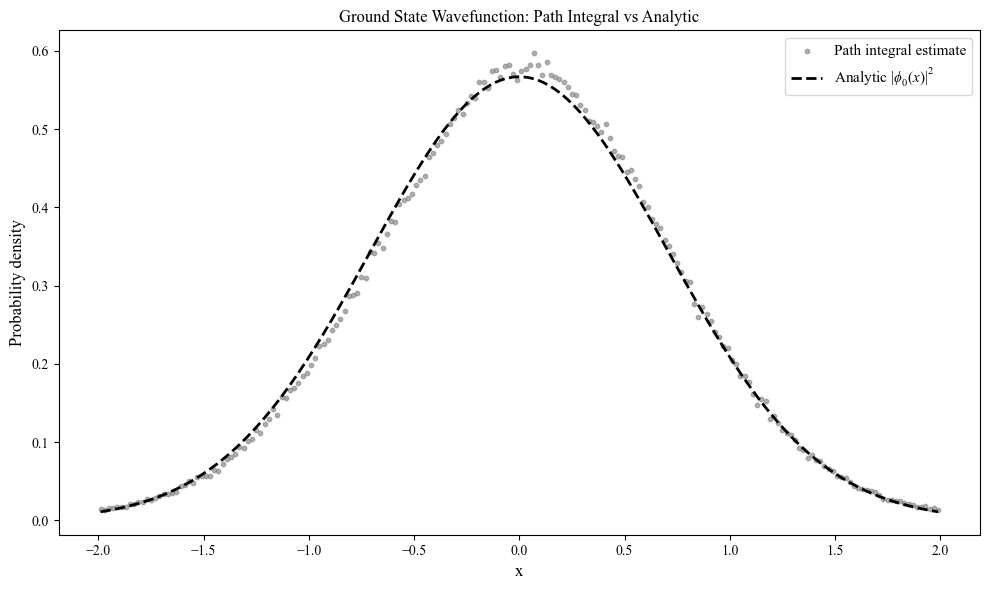

In [95]:
paths_x = np.array([
    MA.Pos_Gen(0.0, 0.0, steps, dt)
    for _ in range(numb_paths)
])

paths_orig = paths_x.copy()
C = 1.8437008005694266
mid = paths_x.shape[1] // 2
thin = 10
sigma_prop = C * np.sqrt(dt)

# Thermalization
print("Thermalizing...")
for sweep in trange(500, desc="Thermalising", mininterval=0):
    acceptances, endpoint_accept = MA.metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if sweep % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

# Sampling
print("\nSampling...")
samples_x = []

for k in trange(5000, desc="Sampling", mininterval=0):
    acceptances, endpoint_accept = MA.metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if k % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

    if k % thin == 0:
        samples_x.append(paths_x[:, -1].copy())

samples_x = np.concatenate(samples_x)

# Compute PDF
x_bins = np.linspace(-2, 2, 201)
pdf_unnormalised_x, bin_edges_x = np.histogram(samples_x, bins=x_bins)

x_centres = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])
dx = np.diff(x_bins)[0]

pdf_x = pdf_unnormalised_x / np.sum(pdf_unnormalised_x * dx)

# Analytic PDF
phi_sq_analytic_x = (1 / np.sqrt(np.pi)) * np.exp(-x_centres ** 2)
phi_sq_analytic_x /= np.sum(phi_sq_analytic_x * dx)

# Statistics
mean_square_x = np.mean(samples_x ** 2)
rms = np.sqrt(mean_square_x)
std = np.std(samples_x)

print("\n------ Results ------")
print(f"Numerical PDF area: {np.sum(pdf_x * dx):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic_x * dx):.5f}")
print(f"Standard deviation: {std:.4f} (expected ≈ 0.707)")
print(f"Root mean square: {rms:.4f} (expected ≈ 0.707)")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x_centres, pdf_x, label='Path integral estimate', s=10, alpha=0.6, color='grey')
plt.plot(x_centres, phi_sq_analytic_x, 'black', linestyle='--', linewidth=2, label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x', fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.legend(fontsize=11)
plt.title('Ground State Wavefunction: Path Integral vs Analytic')

plt.tight_layout()
plt.show()

Thermalizing...


Thermalising:  24%|██▍       | 122/500 [00:00<00:00, 583.09it/s]

Endpoint acceptance ≈ 0.723
Endpoint acceptance ≈ 0.701


Thermalising:  63%|██████▎   | 315/500 [00:00<00:00, 596.77it/s]

Endpoint acceptance ≈ 0.716
Endpoint acceptance ≈ 0.691


Thermalising: 100%|██████████| 500/500 [00:00<00:00, 598.47it/s]


Endpoint acceptance ≈ 0.710

Sampling...


Sampling:   0%|          | 19/5000 [00:00<00:08, 620.39it/s]

Endpoint acceptance ≈ 0.698


Sampling:   2%|▏         | 120/5000 [00:00<00:08, 578.83it/s]

Endpoint acceptance ≈ 0.721


Sampling:   4%|▍         | 219/5000 [00:00<00:08, 596.01it/s]

Endpoint acceptance ≈ 0.708


Sampling:   6%|▋         | 321/5000 [00:00<00:07, 607.17it/s]

Endpoint acceptance ≈ 0.694


Sampling:   8%|▊         | 416/5000 [00:00<00:07, 600.70it/s]

Endpoint acceptance ≈ 0.687


Sampling:  10%|█         | 508/5000 [00:00<00:07, 566.03it/s]

Endpoint acceptance ≈ 0.695


Sampling:  12%|█▏        | 615/5000 [00:01<00:07, 602.68it/s]

Endpoint acceptance ≈ 0.700


Sampling:  14%|█▍        | 716/5000 [00:01<00:07, 553.05it/s]

Endpoint acceptance ≈ 0.706


Sampling:  16%|█▋        | 824/5000 [00:01<00:05, 696.41it/s]

Endpoint acceptance ≈ 0.713


Sampling:  19%|█▊        | 929/5000 [00:01<00:06, 640.37it/s]

Endpoint acceptance ≈ 0.719


Sampling:  21%|██        | 1033/5000 [00:01<00:06, 634.89it/s]

Endpoint acceptance ≈ 0.709


Sampling:  23%|██▎       | 1137/5000 [00:01<00:05, 729.45it/s]

Endpoint acceptance ≈ 0.693


Sampling:  25%|██▍       | 1240/5000 [00:02<00:05, 685.83it/s]

Endpoint acceptance ≈ 0.708


Sampling:  27%|██▋       | 1332/5000 [00:02<00:05, 624.04it/s]

Endpoint acceptance ≈ 0.704


Sampling:  28%|██▊       | 1424/5000 [00:02<00:05, 634.56it/s]

Endpoint acceptance ≈ 0.703


Sampling:  31%|███       | 1529/5000 [00:02<00:05, 640.96it/s]

Endpoint acceptance ≈ 0.679


Sampling:  32%|███▏      | 1622/5000 [00:02<00:06, 556.69it/s]

Endpoint acceptance ≈ 0.698


Sampling:  34%|███▍      | 1719/5000 [00:02<00:05, 631.09it/s]

Endpoint acceptance ≈ 0.722


Sampling:  36%|███▋      | 1818/5000 [00:02<00:05, 614.41it/s]

Endpoint acceptance ≈ 0.713


Sampling:  38%|███▊      | 1904/5000 [00:03<00:07, 397.94it/s]

Endpoint acceptance ≈ 0.683


Sampling:  40%|████      | 2006/5000 [00:03<00:04, 666.27it/s]

Endpoint acceptance ≈ 0.722


Sampling:  44%|████▍     | 2201/5000 [00:03<00:07, 378.06it/s]

Endpoint acceptance ≈ 0.714
Endpoint acceptance ≈ 0.710


Sampling:  49%|████▊     | 2426/5000 [00:04<00:04, 610.34it/s]

Endpoint acceptance ≈ 0.710
Endpoint acceptance ≈ 0.722


Sampling:  53%|█████▎    | 2639/5000 [00:04<00:03, 610.07it/s]

Endpoint acceptance ≈ 0.700
Endpoint acceptance ≈ 0.714


Sampling:  57%|█████▋    | 2839/5000 [00:04<00:02, 761.02it/s]

Endpoint acceptance ≈ 0.689
Endpoint acceptance ≈ 0.706


Sampling:  60%|██████    | 3024/5000 [00:05<00:04, 412.33it/s]

Endpoint acceptance ≈ 0.711
Endpoint acceptance ≈ 0.702


Sampling:  65%|██████▍   | 3242/5000 [00:05<00:02, 745.46it/s]

Endpoint acceptance ≈ 0.720
Endpoint acceptance ≈ 0.699


Sampling:  69%|██████▊   | 3437/5000 [00:05<00:02, 670.45it/s]

Endpoint acceptance ≈ 0.683
Endpoint acceptance ≈ 0.688


Sampling:  73%|███████▎  | 3635/5000 [00:05<00:02, 613.04it/s]

Endpoint acceptance ≈ 0.696
Endpoint acceptance ≈ 0.707


Sampling:  77%|███████▋  | 3832/5000 [00:06<00:01, 671.78it/s]

Endpoint acceptance ≈ 0.706
Endpoint acceptance ≈ 0.693


Sampling:  81%|████████  | 4044/5000 [00:06<00:01, 674.94it/s]

Endpoint acceptance ≈ 0.684
Endpoint acceptance ≈ 0.686


Sampling:  85%|████████▍ | 4234/5000 [00:06<00:01, 707.90it/s]

Endpoint acceptance ≈ 0.708
Endpoint acceptance ≈ 0.734


Sampling:  89%|████████▉ | 4441/5000 [00:07<00:00, 678.47it/s]

Endpoint acceptance ≈ 0.685
Endpoint acceptance ≈ 0.706


Sampling:  93%|█████████▎| 4637/5000 [00:07<00:00, 657.59it/s]

Endpoint acceptance ≈ 0.681
Endpoint acceptance ≈ 0.704


Sampling:  97%|█████████▋| 4834/5000 [00:07<00:00, 673.85it/s]

Endpoint acceptance ≈ 0.724
Endpoint acceptance ≈ 0.725


Sampling: 100%|██████████| 5000/5000 [00:07<00:00, 629.22it/s]


Endpoint acceptance ≈ 0.709

------ Results ------
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000
Standard deviation: 0.8263 (expected ≈ 0.707)
Root mean square: 0.8266 (expected ≈ 0.707)


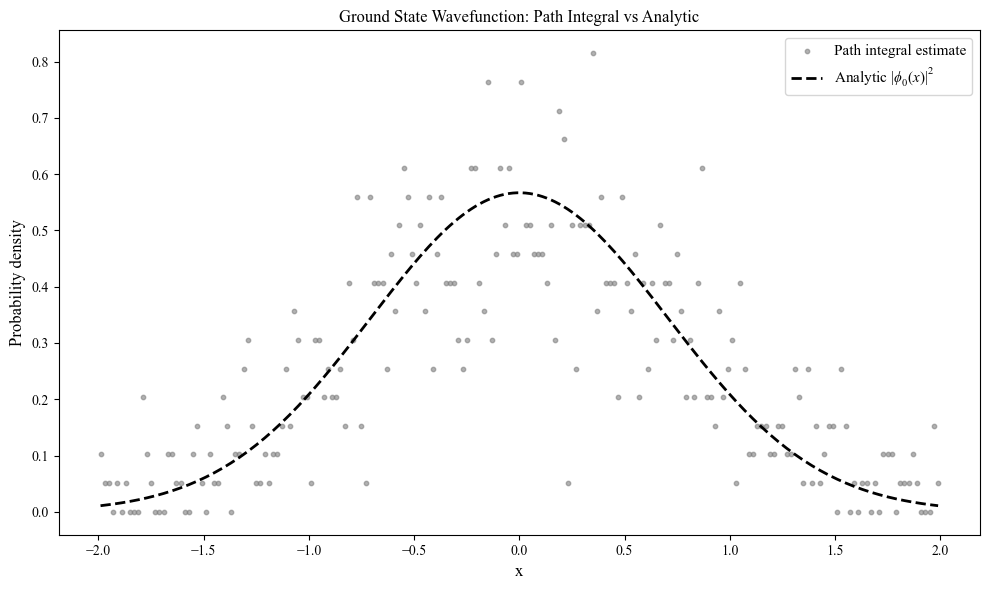

In [135]:
paths_x_unopt = np.array([
    MA.Pos_Gen(0.0, 0.0, steps, dt)
    for _ in range(numb_paths)
])

paths_orig_unopt = paths_x_unopt.copy()
C_unopt = 1
mid_unopt = paths_x_unopt.shape[1] // 2
thin = 10
sigma_prop_unopt = C_unopt * np.sqrt(dt)

# Thermalization
print("Thermalizing...")
for sweep in trange(500, desc="Thermalising", mininterval=0):
    acceptances, endpoint_accept = MA.metropolis_sweep_vectorised(
        paths_x_unopt, times, mass, x_potential, sigma_prop_unopt
    )

    if sweep % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

# Sampling
print("\nSampling...")
samples_x_unopt = []

for k in trange(5000, desc="Sampling", mininterval=0):
    acceptances, endpoint_accept = MA.metropolis_sweep_vectorised(
        paths_x_unopt, times, mass, x_potential, sigma_prop_unopt
    )

    if k % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

    if k % thin == 0:
        samples_x_unopt.append(paths_x[:, -1].copy())

samples_x_unopt = np.concatenate(samples_x_unopt)

# Compute PDF
x_bins = np.linspace(-2, 2, 201)
pdf_unnormalised_x_unopt, bin_edges_x_unopt = np.histogram(samples_x_unopt, bins=x_bins)

x_centres_unopt = 0.5 * (bin_edges_x_unopt[1:] + bin_edges_x_unopt[:-1])
dx = np.diff(x_bins)[0]

pdf_x_unopt = pdf_unnormalised_x_unopt / np.sum(pdf_unnormalised_x_unopt * dx)

# Analytic PDF
phi_sq_analytic_x = (1 / np.sqrt(np.pi)) * np.exp(-x_centres ** 2)
phi_sq_analytic_x /= np.sum(phi_sq_analytic_x * dx)

# Statistics
mean_square_x_unopt = np.mean(samples_x_unopt ** 2)
rms_unopt = np.sqrt(mean_square_x_unopt)
std_unopt = np.std(samples_x_unopt)

print("\n------ Results ------")
print(f"Numerical PDF area: {np.sum(pdf_x_unopt * dx):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic_x * dx):.5f}")
print(f"Standard deviation: {std_unopt:.4f} (expected ≈ 0.707)")
print(f"Root mean square: {rms_unopt:.4f} (expected ≈ 0.707)")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x_centres_unopt, pdf_x_unopt, label='Path integral estimate', s=10, alpha=0.6, color='grey')
plt.plot(x_centres_unopt, phi_sq_analytic_x, 'black', linestyle='--', linewidth=2, label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x', fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.legend(fontsize=11)
plt.title('Ground State Wavefunction: Path Integral vs Analytic')

plt.tight_layout()
plt.show()

# Bootstrapping

In [9]:
def chi_squared(model_params, model, x_data, y_data, y_err):
    residuals = (y_data - model(x_data, *model_params)) / y_err
    chi2 = np.sum(residuals**2)
    return chi2


def gaussian_model(x,A,B):
    return A*np.exp(B*x**2)

In [10]:
#Bootstrapping Metropolis

from tqdm.auto import trange
import numpy as np

def metropolis_pdf_bootstrap(
    n_bootstraps,
    numb_paths,
    steps,
    dt,
    times,
    mass,
    x_potential,
    sigma_prop,
    x_bins,
    n_therm=500,
    n_sample=5000,
    thin=10,
):

    dx = np.diff(x_bins)[0]
    x_centres = 0.5 * (x_bins[1:] + x_bins[:-1])

    pdfs = []

    for b in trange(n_bootstraps, desc="Bootstrap runs"):
        # --- fresh paths ---
        paths_x = np.array([
            MA.Pos_Gen(0.0, 0.0, steps, dt)
            for _ in range(numb_paths)
        ])

        # --- thermalisation ---
        for _ in range(n_therm):
            MA.metropolis_sweep_vectorised(
                paths_x, times, mass, x_potential, sigma_prop
            )

        # --- sampling ---
        samples_x = []

        for k in range(n_sample):
            MA.metropolis_sweep_vectorised(
                paths_x, times, mass, x_potential, sigma_prop
            )

            if k % thin == 0:
                samples_x.append(paths_x[:, -1].copy())

        samples_x = np.concatenate(samples_x)

        # --- PDF ---
        hist, _ = np.histogram(samples_x, bins=x_bins)
        pdf = hist / np.sum(hist * dx)

        pdfs.append(pdf)

    pdfs = np.array(pdfs)

    # --- statistics across runs ---
    pdf_mean = np.mean(pdfs, axis=0)
    pdf_se   = np.std(pdfs, axis=0, ddof=1) / np.sqrt(n_bootstraps)

    return x_centres, pdf_mean, pdf_se

def bootstrap_propagator_pdf(
    x_end_prop,
    weights_prop,
    x_bins_prop,
    n_bootstrap=1000
):
    """
    Bootstrap the propagator PDF from weighted paths.

    Returns:
        x_centres: array
        pdf_mean: array
        pdf_se: array
    """
    dx = np.diff(x_bins_prop)[0]
    x_centres = 0.5 * (x_bins_prop[1:] + x_bins_prop[:-1])

    pdfs = []

    n_paths = len(x_end_prop)
    for _ in trange(n_bootstrap, desc="Bootstrap propagator"):
        # Resample indices with replacement
        indices = np.random.choice(n_paths, size=n_paths, replace=True)
        x_resample = x_end_prop[indices]
        w_resample = weights_prop[indices]

        # Weighted histogram
        hist, _ = np.histogram(x_resample, bins=x_bins_prop, weights=w_resample)
        pdf = hist / np.sum(hist * dx)
        pdfs.append(pdf)

    pdfs = np.array(pdfs)
    pdf_mean = np.mean(pdfs, axis=0)
    pdf_se   = np.std(pdfs, axis=0, ddof=1)

    return x_centres, pdf_mean, pdf_se


In [11]:
x_bins = np.linspace(-2, 2, 201)

x_centres, pdf_mean, pdf_se = metropolis_pdf_bootstrap(
    n_bootstraps=100,
    numb_paths=numb_paths,
    steps=steps,
    dt=dt,
    times=times,
    mass=mass,
    x_potential=x_potential,
    sigma_prop=sigma_prop,
    x_bins=x_bins,
    n_therm=500,
    n_sample=5000,
    thin=10,
)

Bootstrap runs: 100%|██████████| 100/100 [07:07<00:00,  4.27s/it]


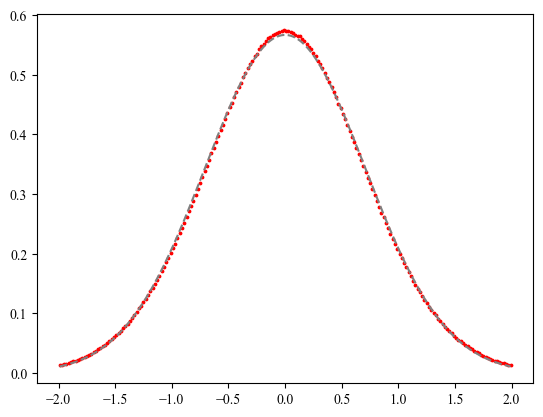

In [12]:
plt.figure(1)
plt.scatter(x_centres, pdf_mean, s = 3, color = "red")
plt.plot(x_centres, phi_sq_analytic_x, 'grey', linestyle = "--")
plt.show()

Bootstrap runs: 100%|██████████| 100/100 [06:21<00:00,  3.82s/it]


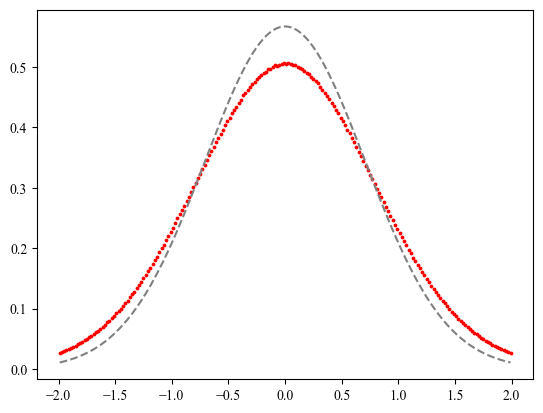

In [130]:
x_centres_metrop_boot2, pdf_mean_metrop_boot2, pdf_se_metrop_boot_2 = metropolis_pdf_bootstrap(
    n_bootstraps=100,
    numb_paths=numb_paths,
    steps=50,
    dt=dt,
    times=times,
    mass=mass,
    x_potential=x_potential,
    sigma_prop=np.sqrt(dt),
    x_bins=x_bins,
    n_therm=500,
    n_sample=5000,
    thin=10,
)

plt.figure(1)
plt.scatter(x_centres_metrop_boot2, pdf_mean_metrop_boot2, s = 3, color = "red")
plt.plot(x_centres, phi_sq_analytic_x, 'grey', linestyle = "--")
plt.show()

In [13]:
x_centres_prop_boot, pdf_mean_prop, pdf_se_prop = bootstrap_propagator_pdf(
    x_end_prop,
    weights_prop,
    x_bins_prop,
    n_bootstrap=500  # tune as desired
)


Bootstrap propagator: 100%|██████████| 500/500 [00:04<00:00, 117.10it/s]


In [140]:
#residuals for propagator

propagator_residuals_normalised = (pdf_mean_prop - phi_sq_analytic_x)/pdf_se_prop
print(np.std(propagator_residuals_normalised))

#residuals for metropolis

metropolis_residiuals_normalised = (pdf_mean - phi_sq_analytic_x)/pdf_se
print(np.std(metropolis_residiuals_normalised))

#residuals for naive metropolis

metropolis_residiuals_normalised_B2 = (pdf_mean_metrop_boot2 - phi_sq_analytic_x)/pdf_se_metrop_boot_2
print(np.std(metropolis_residiuals_normalised_B2))

1.4495518718771108
4.026683559127763
40.06757760414866


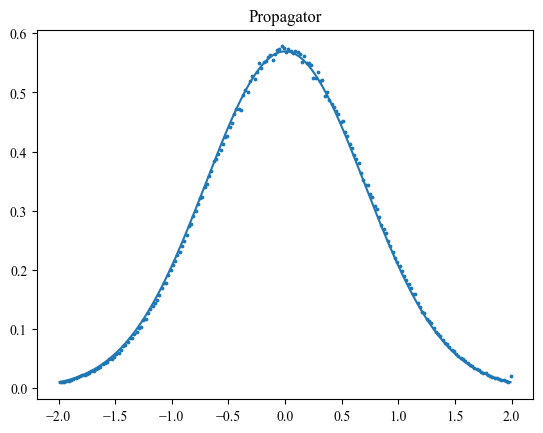

----- Propagator -----
A = 0.569 ± 0.000
B = -1.013 ± 0.000
Red_chi2 = 1.8986
----- ----- ----- -----


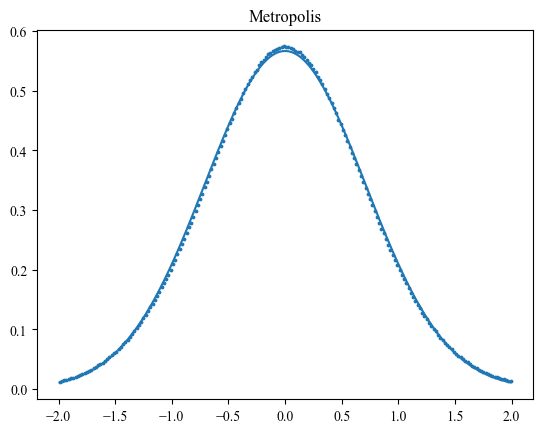

----- Metropolis -----
A = 0.567 ± 0.000
B = -0.996 ± 0.000
Red_chi2 = 16.7428
----- ----- ----- -----


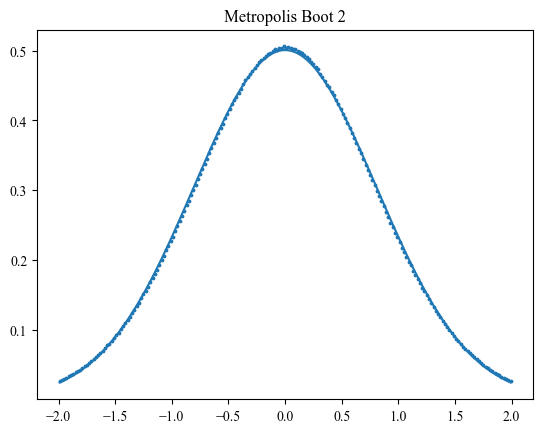

----- Metropolis -----
A = 0.501 ± 0.000
B = -0.766 ± 0.000
Red_chi2 = 10.0866
----- ----- ----- -----


In [131]:
# goodness of fit testing
p0_gaussian = [0.505,1]

popt_prop, cov_prop = curve_fit(gaussian_model,
                                x_centres,
                                pdf_prop,
                                sigma = pdf_se_prop,
                                absolute_sigma = True,
                                p0 = p0_gaussian)

popt_metrop, cov_metrop = curve_fit(gaussian_model,
                                    x_centres,
                                    pdf_mean,
                                    sigma = pdf_se,
                                    absolute_sigma= True,
                                    p0 = p0_gaussian)

popt_metrop_boot2, cov_metrop_boot2 = curve_fit(gaussian_model,
                                                x_centres,
                                                pdf_mean_metrop_boot2,
                                                sigma=pdf_se_metrop_boot_2,
                                                absolute_sigma=True,
                                                p0 = p0_gaussian)

chi2_metrop = chi_squared(
    popt_metrop,
    gaussian_model,
    x_data=x_centres,
    y_data=pdf_mean,
    y_err=pdf_se
)
dof_metrop = len(x_centres) - len(popt_metrop)

red_chi2_metrop = chi2_metrop/dof_metrop

chi2_prop = chi_squared(
    popt_prop,
    gaussian_model,
    x_data=x_centres,
    y_data=pdf_mean_prop,
    y_err=pdf_se_prop
)
dof_prop = len(x_centres) - len(popt_prop)

red_chi2_prop = chi2_prop/dof_prop

chi2_metrop_B2 = chi_squared(
    popt_metrop_boot2,
    gaussian_model,
    x_data=x_centres,
    y_data=pdf_mean_metrop_boot2,
    y_err=pdf_se_metrop_boot_2
)
dof_metrop_B2 = len(x_centres) - len(popt_metrop_boot2)

red_chi2_metrop_B2 = chi2_metrop_B2/dof_metrop_B2

plt.figure(1)
plt.title("Propagator")
plt.scatter(x_centres,pdf_prop, s =3)
plt.plot(x_centres,gaussian_model(x_centres,*popt_prop))
plt.show()
print(f"----- Propagator -----")
print(f"A = {popt_prop[0]:.3f} ± {np.std(cov_prop[0][0]):.3f}")
print(f"B = {popt_prop[1]:.3f} ± {np.std(cov_prop[1][1]):.3f}")
print(f"Red_chi2 = {red_chi2_prop:.4f}")
print(f"----- ----- ----- -----")

plt.figure(2)
plt.title("Metropolis")
plt.scatter(x_centres,pdf_mean, s =3)
plt.plot(x_centres,gaussian_model(x_centres,*popt_metrop))
plt.show()
print(f"----- Metropolis -----")
print(f"A = {popt_metrop[0]:.3f} ± {np.std(cov_metrop[0][0]):.3f}")
print(f"B = {popt_metrop[1]:.3f} ± {np.std(cov_metrop[1][1]):.3f}")
print(f"Red_chi2 = {red_chi2_metrop:.4f}")
print(f"----- ----- ----- -----")

plt.figure(2)
plt.title("Metropolis Boot 2")
plt.scatter(x_centres,pdf_mean_metrop_boot2, s =3)
plt.plot(x_centres,gaussian_model(x_centres,*popt_metrop_boot2))
plt.show()
print(f"----- Metropolis -----")
print(f"A = {popt_metrop_boot2[0]:.3f} ± {np.std(cov_metrop_boot2[0][0]):.3f}")
print(f"B = {popt_metrop_boot2[1]:.3f} ± {np.std(cov_metrop_boot2[1][1]):.3f}")
print(f"Red_chi2 = {red_chi2_metrop_B2:.4f}")
print(f"----- ----- ----- -----")

# Other shit Im not sure about

In [46]:
def model_pdf(x, B, dx):
    unnorm = np.exp(B * x**2)
    A = 1.0 / np.sum(unnorm * dx)
    return A * unnorm

def neg_log_likelihood(B, x, pdf_data, dx):
    pdf_model = model_pdf(x, B, dx)

    mask = pdf_data > 0
    return np.sum(
        pdf_data[mask] * np.log(pdf_data[mask] / pdf_model[mask])
    ) * dx


In [30]:
#model fitting

from scipy.optimize import minimize

dx = x_centres[1] - x_centres[0]

res_prop = minimize(
    neg_log_likelihood,
    x0=-1.0,
    args=(x_centres, pdf_prop, dx)
)

res_metro = minimize(
    neg_log_likelihood,
    x0=-1.0,
    args=(x_centres, pdf_x, dx)
)

B_prop = res_prop.x[0]
B_metro = res_metro.x[0]

print(f"B (propagator) = {B_prop:.6f}")
print(f"B (metropolis) = {B_metro:.6f}")


B (propagator) = -1.012434
B (metropolis) = -0.982662


In [31]:
def bootstrap_B(x, pdf, dx, n_boot=500):
    Bs = []
    for _ in range(n_boot):
        noise = np.random.normal(0, np.sqrt(pdf / np.sum(pdf)), size=pdf.size)
        pdf_boot = pdf + noise
        pdf_boot = np.clip(pdf_boot, 0, None)
        pdf_boot /= np.sum(pdf_boot * dx)

        res = minimize(
            neg_log_likelihood,
            x0=-1.0,
            args=(x, pdf_boot, dx)
        )
        Bs.append(res.x[0])
    return np.array(Bs)

Bs_prop = bootstrap_B(x_centres, pdf_prop, dx)
Bs_metro = bootstrap_B(x_centres, pdf_x, dx)

print("Propagator: ", Bs_prop.mean(), Bs_prop.std())
print("Metropolis: ", Bs_metro.mean(), Bs_metro.std())


Propagator:  -1.0028614874023436 0.030042857776806042
Metropolis:  -0.9745729221969635 0.029707850982850503


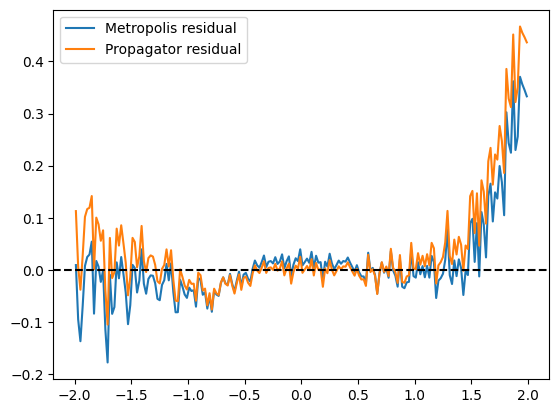

In [34]:
KL_prop = neg_log_likelihood(B_prop, x_centres, pdf_prop, dx)
KL_metro = neg_log_likelihood(B_metro, x_centres, pdf_x, dx)

plt.plot(
    x_centres,
    np.log(pdf_x) - np.log(model_pdf(x_centres, B_metro, dx)),
    label="Metropolis residual"
)
plt.plot(
    x_centres,
    np.log(pdf_x) - np.log(model_pdf(x_centres, B_prop, dx)),
    label="Propagator residual"
)
plt.axhline(0, color='k', ls='--')
plt.legend()


Bootstrapping: 100%|██████████| 1000/1000 [02:53<00:00,  5.75it/s]


B = -0.964090
σ_B = 0.002023
68% CI = [-0.966113, -0.962109]


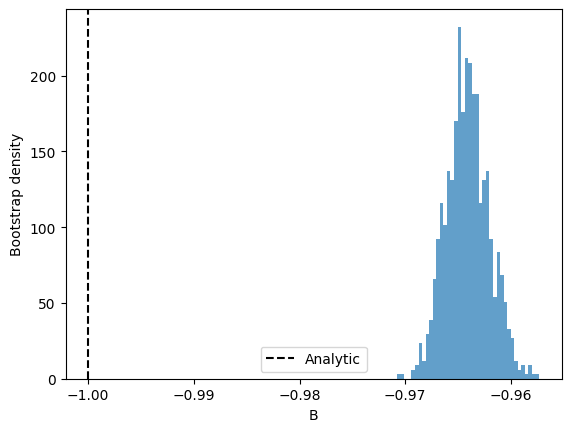

In [39]:
def neg_log_likelihood_raw(B, samples):
    # evaluate model on the samples themselves
    pdf_vals = np.exp(B * samples**2)

    # normalisation constant
    # (compute on a fine grid for stability)
    x_grid = np.linspace(-5, 5, 4001)
    Z = np.trapezoid(np.exp(B * x_grid**2), x_grid)

    return -np.sum(np.log(pdf_vals / Z))

def bootstrap_B_raw(samples, n_boot=1000):
    N = len(samples)
    B_boot = np.empty(n_boot)

    for i in trange(n_boot, desc="Bootstrapping"):
        # resample with replacement
        boot_samples = np.random.choice(samples, size=N, replace=True)

        res = minimize(
            neg_log_likelihood_raw,
            x0=-1.0,
            args=(boot_samples,),
            method="Nelder-Mead"
        )

        B_boot[i] = res.x[0]

    return B_boot

B_boot = bootstrap_B_raw(samples_x, n_boot=1000)

B_mean = np.mean(B_boot)
B_std  = np.std(B_boot)
B_ci   = np.percentile(B_boot, [16, 84])

print(f"B = {B_mean:.6f}")
print(f"σ_B = {B_std:.6f}")
print(f"68% CI = [{B_ci[0]:.6f}, {B_ci[1]:.6f}]")

plt.hist(B_boot, bins=40, density=True, alpha=0.7)
plt.axvline(-1, color='k', ls='--', label='Analytic')
plt.xlabel("B")
plt.ylabel("Bootstrap density")
plt.legend()
plt.show()


# Calculations for plot

In [137]:
#SE ribbon for propagator
y_max_prop = gaussian_model(x_centres, popt_prop[0] + np.sqrt(cov_prop[0][0]), popt_prop[1] + np.sqrt(cov_prop[1][1]))
y_min_prop = gaussian_model(x_centres, popt_prop[0] - np.sqrt(cov_prop[0][0]), popt_prop[1] - np.sqrt(cov_prop[1][1]))

#SE ribbon for metropolis
y_max_metrop = gaussian_model(x_centres, popt_metrop[0] + np.sqrt(cov_metrop[0][0]), popt_metrop[1] + np.sqrt(cov_metrop[1][1]))
y_min_metrop = gaussian_model(x_centres, popt_metrop[0] - np.sqrt(cov_metrop[0][0]), popt_metrop[1] - np.sqrt(cov_metrop[1][1]))

#SE ribbon for naive metropolis
y_max_metrop_B2 = gaussian_model(x_centres, popt_metrop_boot2[0] + np.sqrt(cov_metrop_boot2[0][0]), popt_metrop_boot2[1] + np.sqrt(cov_metrop_boot2[1][1]))
y_min_metrop_B2 = gaussian_model(x_centres, popt_metrop_boot2[0] - np.sqrt(cov_metrop_boot2[0][0]), popt_metrop_boot2[1] - np.sqrt(cov_metrop_boot2[1][1]))

In [138]:
print(len(pdf_mean))
print(len(pdf_mean_prop))
print(len(pdf_mean_metrop_boot2))

def bin_by_4(x, y, yerr, bin_size=4):
    n_bins = len(x) // bin_size

    x_b = x[:n_bins * bin_size].reshape(n_bins, bin_size).mean(axis=1)
    y_b = y[:n_bins * bin_size].reshape(n_bins, bin_size).mean(axis=1)
    yerr_b = np.sqrt(
        (yerr[:n_bins * bin_size].reshape(n_bins, bin_size) ** 2).sum(axis=1)
    ) / bin_size

    return x_b, y_b, yerr_b

200
200
200


In [150]:
x_binned, pdf_binned_metrop, pdf_binned_metrop_err = bin_by_4(x_centres, pdf_mean, pdf_se) #metropolis
x_binned, y_max_metrop_binned, filler = bin_by_4(x_centres, y_max_metrop, pdf_se)
x_binned, y_min_metrop_binned, filler = bin_by_4(x_centres, y_min_metrop, pdf_se)


x_binned, pdf_binned_prop, pdf_binned_prop_err = bin_by_4(x_centres, pdf_mean_prop, pdf_se_prop) #propagator
x_binned, y_max_prop_binned, filler = bin_by_4(x_centres, y_max_prop, pdf_se)
x_binned, y_min_prop_binned, filler = bin_by_4(x_centres, y_min_prop, pdf_se)

x_binned, pdf_binned_metrop_B2, pdf_binned_metrop_err_B2 = bin_by_4(x_centres, pdf_mean_metrop_boot2, pdf_se_metrop_boot_2) #naive metropolis
x_binned, y_max_metrop_binned_B2, filler = bin_by_4(x_centres, y_max_metrop_B2, pdf_se_metrop_boot_2)
x_binned, y_min_metrop_binned_B2, filler = bin_by_4(x_centres, y_min_metrop_B2, pdf_se_metrop_boot_2)


x_binned, pdf_analytic_binned, filler = bin_by_4(x_centres, phi_sq_analytic_x, pdf_se) #analytic




#residuals for propagator

binned_propagator_residuals_normalised = (pdf_binned_prop - pdf_analytic_binned)/pdf_binned_prop_err
print(np.std(binned_propagator_residuals_normalised))

#residuals for metropolis

binned_metropolis_residuals_normalised = (pdf_binned_metrop - pdf_analytic_binned)/pdf_binned_metrop_err
print(np.std(binned_metropolis_residuals_normalised))

#residuals for naive metropolis

binned_metropolis_residuals_normalised_B2 = (pdf_binned_metrop_B2 - pdf_analytic_binned)/pdf_binned_metrop_err_B2
print(np.std(binned_metropolis_residuals_normalised_B2))

2.099456987747732
7.969159682247865
79.78361582130667


# Individual Main Plots

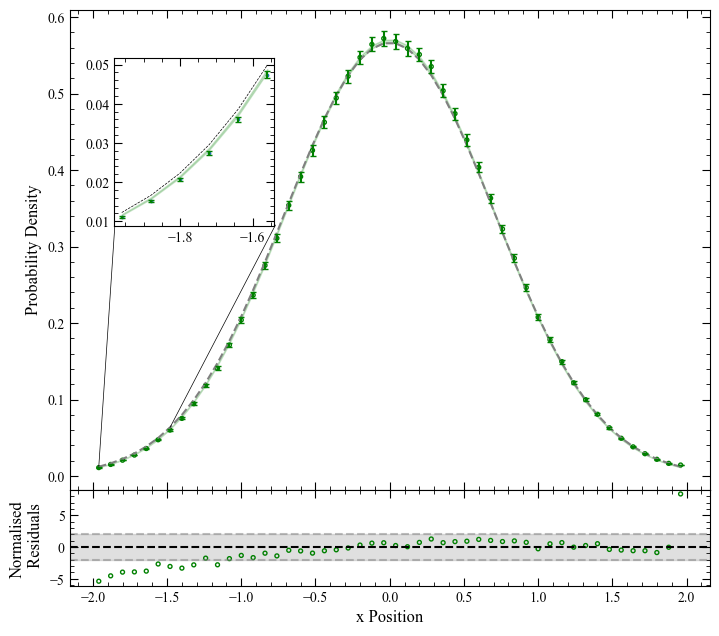

200
50


In [19]:
#plot for propagator

laptop_savepath_main_results_propagator = r"C:\Users\sebas\Documents\Durham Work\Year 3\Comp Phys\main_results_propagator.svg"
pc_savepath_main_results_propagator = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\main_results_propagator.svg"

fig = plt.figure(1)

#main plot 1
fig.add_axes([0,0,1,1])
plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

plt.plot(x_binned, pdf_analytic_binned, linestyle = "--", color = "grey", label = "Theoretical")

plt.scatter(x_binned, pdf_binned_prop, marker = "o", s = 8, color = "green", facecolor = "none", label = "Propagator")
plt.errorbar(x_binned, pdf_binned_prop, yerr = pdf_binned_prop_err, linestyle = "none", color = "green", capsize = 2)

# plt.scatter(x_centres[-1], pdf_mean_prop[-1], marker = "o", s = 8, color = "red", label = "Outlier")

plt.fill_between(x_binned, y_max_prop_binned, y_min_prop_binned, color = "green", alpha = 0.2, label = "Se Ribbon")

plt.ylabel("Probability Density", fontsize=12)


#Inset
start_index = 0
end_index = 6
plt.plot([x_binned[start_index],-1.85],[pdf_analytic_binned[start_index], 0.333], color = 'black', linewidth = 0.5) #left line
plt.plot([x_binned[end_index],-0.77],[pdf_analytic_binned[end_index], 0.328], color = 'black', linewidth = 0.5) #right line

inset = fig.add_axes([0.07, 0.55, 0.25, 0.35])

inset.errorbar(x_binned[start_index:end_index], pdf_binned_prop[start_index:end_index],yerr = pdf_binned_prop_err[start_index:end_index], color = "green", linestyle ='none', capsize = 2) #error bars
inset.plot(x_binned[start_index:end_index],pdf_analytic_binned[start_index:end_index], color = 'black', linewidth = 0.5, linestyle = "--") #analytic
inset.scatter(x_binned[start_index:end_index], pdf_binned_prop[start_index:end_index], s=3) #data

inset.fill_between(x_binned[start_index:end_index],y_min_prop_binned[start_index:end_index], y_max_prop_binned[start_index:end_index], color = "green", alpha = 0.2) #se ribbon

inset.minorticks_on()
inset.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
inset.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')


#residual plot 1
rp1 = fig.add_axes(([0,-0.2,1,0.2]))
plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

rp1.axhline(0, color = 'black', linestyle = '--')
rp1.axhline(np.std(binned_propagator_residuals_normalised), color = 'grey', linestyle = '--',alpha = 0.5)
rp1.axhline(-np.std(binned_propagator_residuals_normalised), color = 'grey', linestyle = '--',alpha = 0.5)
rp1.axhspan(-np.std(binned_propagator_residuals_normalised), np.std(binned_propagator_residuals_normalised), color='grey', alpha=0.25)

plt.scatter(x_binned, binned_propagator_residuals_normalised, marker = "o", s = 8, color = "green", facecolor = "none")

plt.xlabel("x Position", fontsize=12)
rp1.set_ylabel("Normalised \n Residuals",fontsize=12)
# rp1.yaxis.set_label_coords(-0.05,1)


plt.savefig(pc_savepath_main_results_propagator, bbox_inches = 'tight')
plt.show()

print(len(phi_sq_analytic_x))
print(len(binned_propagator_residuals_normalised))

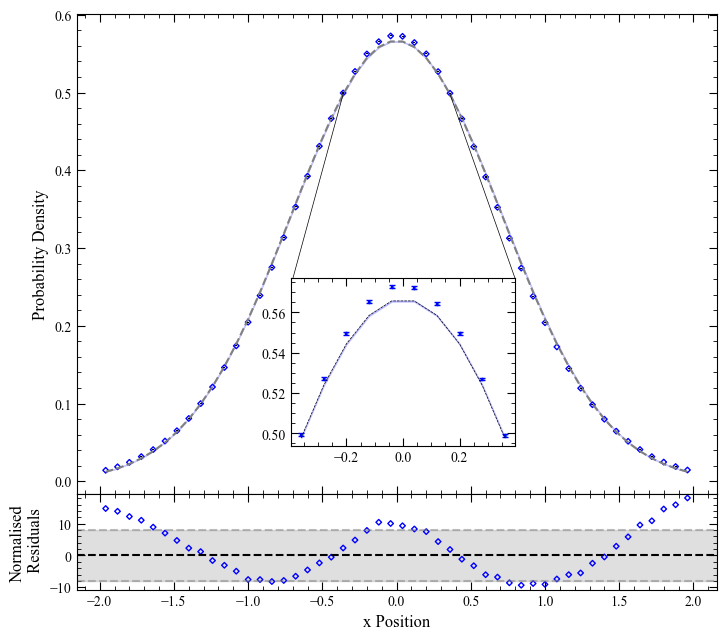

In [20]:
#plot for metropolis

laptop_savepath_main_results_metropolis = r"C:\Users\sebas\Documents\Durham Work\Year 3\Comp Phys\main_results_metropolis.svg"
pc_savepath_main_results_metropolis = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\main_results_metropolis.svg"

fig = plt.figure(1)

#main plot 2
plt2 = fig.add_axes([0,0,1,1])


plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

plt.plot(x_binned, pdf_analytic_binned, linestyle = "--", color = "grey", label = "Theoretical")

plt.scatter(x_binned, pdf_binned_metrop, marker = "D", s = 8,color = "blue", facecolor = "none", label = "Metropolis")
plt.errorbar(x_binned, pdf_binned_metrop, yerr= pdf_binned_metrop_err, linestyle = "none", color = "black")
plt.fill_between(x_binned, y_max_metrop_binned, y_min_metrop_binned, color = "blue", alpha = 0.2)

plt.ylabel("Probability Density", fontsize=12)


#Inset
start_index = 20
end_index = 30
plt.plot([x_binned[start_index],-0.7],[pdf_analytic_binned[start_index], 0.26], color = 'black', linewidth = 0.5) #left line
plt.plot([x_binned[end_index-1],0.8],[pdf_analytic_binned[end_index-1], 0.26], color = 'black', linewidth = 0.5) #right line

inset = fig.add_axes([0.335, 0.1, 0.35, 0.35])

inset.errorbar(x_binned[start_index:end_index], pdf_binned_metrop[start_index:end_index],yerr = pdf_binned_metrop_err[start_index:end_index], color = "blue", linestyle ='none', capsize = 2) #error bars
inset.plot(x_binned[start_index:end_index],pdf_analytic_binned[start_index:end_index], color = 'black',linestyle = "--", linewidth = 0.5) #analytic
inset.scatter(x_binned[start_index:end_index], pdf_binned_metrop[start_index:end_index], s=3) #data

inset.fill_between(x_binned[start_index:end_index],y_min_metrop_binned[start_index:end_index], y_max_metrop_binned[start_index:end_index], color = "blue", alpha = 0.2) #se ribbon

inset.minorticks_on()
inset.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
inset.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')


#residual plot 2
rp2 = fig.add_axes(([0,-0.2,1,0.2]))

plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

rp2.axhline(0, color = 'black', linestyle = '--')
rp2.axhline(np.std(binned_metropolis_residuals_normalised), color = 'grey', linestyle = '--',alpha = 0.5)
rp2.axhline(-np.std(binned_metropolis_residuals_normalised), color = 'grey', linestyle = '--',alpha = 0.5)
rp2.axhspan(-np.std(binned_metropolis_residuals_normalised), np.std(binned_metropolis_residuals_normalised), color='grey', alpha=0.25)

plt.scatter(x_binned, binned_metropolis_residuals_normalised, marker = "D", s = 8,color = "blue", facecolor = "none")

plt.xlabel("x Position", fontsize=12)
plt.ylabel("Normalised \n Residuals",fontsize=12)

plt.savefig(pc_savepath_main_results_metropolis, bbox_inches = 'tight')
plt.show()

# Combined Main Plot

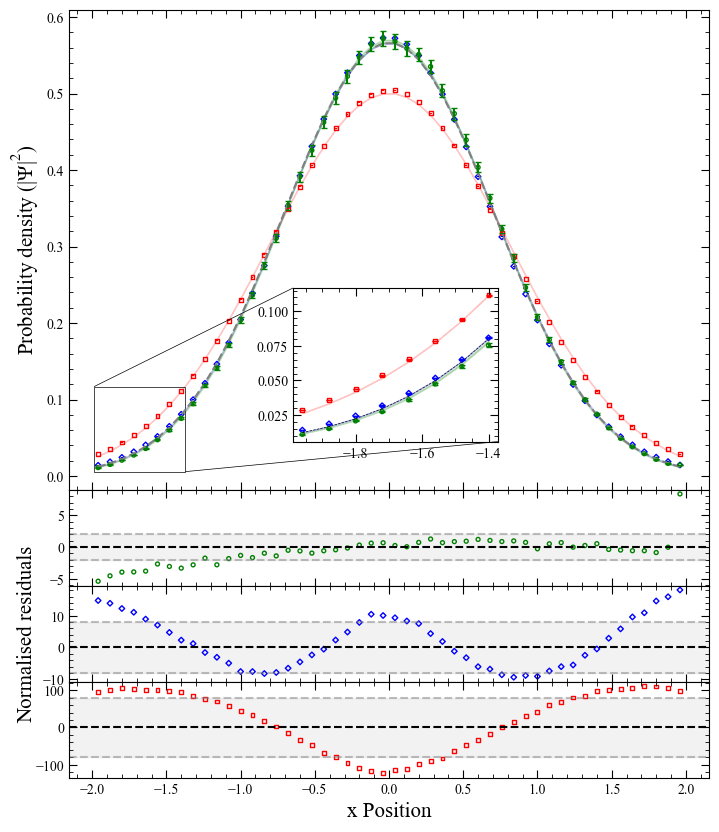

In [151]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

#combined plot

#plot for metropolis

laptop_savepath_main_results_combined = r"C:\Users\sebas\Documents\Durham Work\Year 3\Comp Phys\main_results_combined.svg"
pc_savepath_main_results_combined = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\main_results_combined.svg"

fig = plt.figure(1)

#main plot 2
plt2 = fig.add_axes([0,0,1,1])


plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

plt.plot(x_binned, pdf_analytic_binned, linestyle = "--", color = "grey", label = "Theoretical")


#optimised
plt.scatter(x_binned, pdf_binned_metrop, marker = "D", s = 8,color = "blue", facecolor = "none", label = "Metropolis")
plt.errorbar(x_binned, pdf_binned_metrop, yerr= pdf_binned_metrop_err, linestyle = "none", color = "blue")
plt.fill_between(x_binned, y_max_metrop_binned, y_min_metrop_binned, color = "blue", alpha = 0.2)


#propagator
plt.scatter(x_binned, pdf_binned_prop, marker = "o", s = 8, color = "green", facecolor = "none", label = "Propagator")
plt.errorbar(x_binned, pdf_binned_prop, yerr = pdf_binned_prop_err, linestyle = "none", color = "green", capsize = 2)
plt.fill_between(x_binned, y_max_prop_binned, y_min_prop_binned, color = "green", alpha = 0.2, label = "Se Ribbon")


#naive
plt.scatter(x_binned, pdf_binned_metrop_B2, marker = "s", s = 8,color = "red", facecolor = "none", label = "Naive Metropolis")
plt.errorbar(x_binned, pdf_binned_metrop_B2, yerr= pdf_binned_metrop_err_B2, linestyle = "none", color = "red")
plt.fill_between(x_binned, y_max_metrop_binned_B2, y_min_metrop_binned_B2, color = "red", alpha = 0.2)


plt.ylabel(r"Probability density ($| \Psi |^2$)", fontsize=15)


# #Inset for centre
# start_index = 20
# end_index = 30
# inset = fig.add_axes([0.35, 0.1, 0.32, 0.32])
#
# mark_inset(plt2, inset, loc1=2, loc2=1, fc="none", ec="black", lw=0.5)
#
# inset.plot(x_binned[start_index:end_index],pdf_analytic_binned[start_index:end_index], color = 'black',linestyle = "--", linewidth = 0.5) #analytic
#
# inset.errorbar(x_binned[start_index:end_index], pdf_binned_metrop[start_index:end_index],yerr = pdf_binned_metrop_err[start_index:end_index], color = "blue", linestyle ='none', capsize = 2) #error bars
# inset.scatter(x_binned[start_index:end_index], pdf_binned_metrop[start_index:end_index], s=8, color = 'blue', marker = "D", facecolor = "none") #data
# inset.fill_between(x_binned[start_index:end_index],y_min_metrop_binned[start_index:end_index], y_max_metrop_binned[start_index:end_index], color = "blue", alpha = 0.2) #se ribbon
#
# inset.errorbar(x_binned[start_index:end_index], pdf_binned_prop[start_index:end_index],yerr = pdf_binned_prop_err[start_index:end_index], color = "green", linestyle ='none', capsize = 2) #error bars
# inset.scatter(x_binned[start_index:end_index], pdf_binned_prop[start_index:end_index], s=8, color = 'green', marker = "o", facecolor = "none") #data
# inset.fill_between(x_binned[start_index:end_index],y_min_prop_binned[start_index:end_index], y_max_prop_binned[start_index:end_index], color = "green", alpha = 0.2) #se ribbon

#Inset for bottom left
start_index = 0
end_index = 8
inset = fig.add_axes([0.35, 0.1, 0.32, 0.32])

mark_inset(plt2, inset, loc1=2, loc2=4, fc="none", ec="black", lw=0.5)

inset.plot(x_binned[start_index:end_index],pdf_analytic_binned[start_index:end_index], color = 'black',linestyle = "--", linewidth = 0.5) #analytic

#metropolis
inset.errorbar(x_binned[start_index:end_index], pdf_binned_metrop[start_index:end_index],yerr = pdf_binned_metrop_err[start_index:end_index], color = "blue", linestyle ='none', capsize = 2) #error bars
inset.scatter(x_binned[start_index:end_index], pdf_binned_metrop[start_index:end_index], s=8, color = 'blue', marker = "D", facecolor = "none") #data
inset.fill_between(x_binned[start_index:end_index],y_min_metrop_binned[start_index:end_index], y_max_metrop_binned[start_index:end_index], color = "blue", alpha = 0.2) #se ribbon

#propagator
inset.errorbar(x_binned[start_index:end_index], pdf_binned_prop[start_index:end_index],yerr = pdf_binned_prop_err[start_index:end_index], color = "green", linestyle ='none', capsize = 2) #error bars
inset.scatter(x_binned[start_index:end_index], pdf_binned_prop[start_index:end_index], s=8, color = 'green', marker = "o", facecolor = "none") #data
inset.fill_between(x_binned[start_index:end_index],y_min_prop_binned[start_index:end_index], y_max_prop_binned[start_index:end_index], color = "green", alpha = 0.2) #se ribbon

#naive metropolis
inset.errorbar(x_binned[start_index:end_index], pdf_binned_metrop_B2[start_index:end_index],yerr = pdf_binned_metrop_err_B2[start_index:end_index], color = "red", linestyle ='none', capsize = 2) #error bars
inset.scatter(x_binned[start_index:end_index], pdf_binned_metrop_B2[start_index:end_index], s=8, color = 'red', marker = "s", facecolor = "none") #data
inset.fill_between(x_binned[start_index:end_index],y_min_metrop_binned_B2[start_index:end_index], y_max_metrop_binned_B2[start_index:end_index], color = "red", alpha = 0.2) #se ribbon

inset.minorticks_on()
inset.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
inset.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

#residual plot 1
rp1 = fig.add_axes(([0,-0.2,1,0.2]))
plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

rp1.axhline(0, color = 'black', linestyle = '--')
rp1.axhline(np.std(binned_propagator_residuals_normalised), color = 'grey', linestyle = '--',alpha = 0.5)
rp1.axhline(-np.std(binned_propagator_residuals_normalised), color = 'grey', linestyle = '--',alpha = 0.5)
rp1.axhspan(-np.std(binned_propagator_residuals_normalised), np.std(binned_propagator_residuals_normalised), color='grey', alpha=0.1)

plt.scatter(x_binned, binned_propagator_residuals_normalised, marker = "o", s = 8, color = "green", facecolor = "none")


#residual plot 2
rp2 = fig.add_axes(([0,-0.4,1,0.2]))

plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

rp2.axhline(0, color = 'black', linestyle = '--')
rp2.axhline(np.std(binned_metropolis_residuals_normalised), color = 'grey', linestyle = '--',alpha = 0.5)
rp2.axhline(-np.std(binned_metropolis_residuals_normalised), color = 'grey', linestyle = '--',alpha = 0.5)
rp2.axhspan(-np.std(binned_metropolis_residuals_normalised), np.std(binned_metropolis_residuals_normalised), color='grey', alpha=0.1)

plt.ylabel("Normalised residuals",fontsize=15)

plt.scatter(x_binned, binned_metropolis_residuals_normalised, marker = "D", s = 8,color = "blue", facecolor = "none")

#residual plot 3
rp2 = fig.add_axes(([0,-0.6,1,0.2]))

plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

rp2.axhline(0, color = 'black', linestyle = '--')
rp2.axhline(np.std(binned_metropolis_residuals_normalised_B2), color = 'grey', linestyle = '--',alpha = 0.5)
rp2.axhline(-np.std(binned_metropolis_residuals_normalised_B2), color = 'grey', linestyle = '--',alpha = 0.5)
rp2.axhspan(-np.std(binned_metropolis_residuals_normalised_B2), np.std(binned_metropolis_residuals_normalised_B2), color='grey', alpha=0.1)

plt.scatter(x_binned, binned_metropolis_residuals_normalised_B2, marker = "s", s = 8,color = "red", facecolor = "none")

plt.xlabel("x Position", fontsize=15)

plt.savefig(pc_savepath_main_results_combined, bbox_inches = 'tight')
plt.show()

In [132]:
i_099 = np.searchsorted(x_centres, 0.99)
i_101 = np.searchsorted(x_centres, 1.01)

In [134]:
analytical = np.sum(phi_sq_analytic_x[i_099:i_101]*dx)
propagator = np.sum(gaussian_model(x_centres[i_099:i_101],*popt_prop)*dx)
naive_metropolis = np.sum(gaussian_model(x_centres[i_099:i_101],*popt_metrop_boot2)*dx)
opt_metropolis = np.sum(gaussian_model(x_centres[i_099:i_101],*popt_metrop)*dx)


print(f"---- ---- Results Table ---- ----")
print(f"---- Probabilities ----")
print(f"analytical: {analytical}")
print(f"propagator: {propagator}")
print(f"naive metropolis: {naive_metropolis}")
print(f"optimised metropolis: {opt_metropolis}")

print(f"---- Red chi2 ----")
print(f"analytical: -")
print(f"propagator: {red_chi2_prop}")
print(f"naive metropolis: {red_chi2_metrop_B2}")
print(f"optimised metropolis: {red_chi2_metrop}")

print(f"---- A ----")
print(f"analytical: {1/np.sqrt(np.pi)}")
print(f"propagator: {popt_prop[0]} ± {np.sqrt(cov_prop[0][0])}")
print(f"naive metropolis: {popt_metrop_boot2[0]}")
print(f"optimised metropolis: {popt_metrop[0]}")

print(f"---- A 95% CI----")
print(f"analytical: {1/np.sqrt(np.pi)}")
print(f"propagator: [{popt_prop[0]-1.96*np.sqrt(cov_prop[0][0])},{popt_prop[0]+1.96*np.sqrt(cov_prop[0][0])}]  ")
print(f"naive metropolis: [{popt_metrop_boot2[0]-1.96*np.sqrt(cov_metrop_boot2[0][0])},{popt_metrop_boot2[0]+1.96*np.sqrt(cov_metrop_boot2[0][0])}]")
print(f"optimised metropolis: [{popt_metrop[0]-1.96*np.sqrt(cov_metrop[0][0])},{popt_metrop[0]+1.96*np.sqrt(cov_metrop[0][0])}]")

print(f"---- B ----")
print(f"analytical: {-1}")
print(f"propagator: {popt_prop[1]}")
print(f"naive metropolis: {popt_metrop_boot2[1]}")
print(f"optimised metropolis: {popt_metrop[1]}")

print(f"---- B 95% CI----")
print(f"analytical: {-1}")
print(f"propagator: [{popt_prop[1]+1.96*np.sqrt(cov_prop[1][1])},{popt_prop[1]-1.96*np.sqrt(cov_prop[1][1])}]  ")
print(f"naive metropolis: [{popt_metrop_boot2[1]+1.96*np.sqrt(cov_metrop_boot2[1][1])},{popt_metrop_boot2[1]-1.96*np.sqrt(cov_metrop_boot2[1][1])}]")
print(f"optimised metropolis: [{popt_metrop[1]+1.96*np.sqrt(cov_metrop[1][1])},{popt_metrop[1]-1.96*np.sqrt(cov_metrop[1][1])}]")

---- ---- Results Table ---- ----
---- Probabilities ----
analytical: 0.004254403892065026
propagator: 0.004220683035307689
naive metropolis: 0.00472834696901589
optimised metropolis: 0.004271724719232083
---- Red chi2 ----
analytical: -
propagator: 1.8985791224842177
naive metropolis: 10.086550194740749
optimised metropolis: 16.742783803891342
---- A ----
analytical: 0.5641895835477563
propagator: 0.5694508044174307 ± 0.002041209300707989
naive metropolis: 0.5009608495843149
optimised metropolis: 0.5667151371905084
---- A 95% CI----
analytical: 0.5641895835477563
propagator: [0.5654500341880431,0.5734515746468183]  
naive metropolis: [0.5006777639450516,0.5012439352235781]
optimised metropolis: [0.5663329076095761,0.5670973667714406]
---- B ----
analytical: -1
propagator: -1.0128072831898822
naive metropolis: -0.7661761908459802
optimised metropolis: -0.9956291269349395
---- B 95% CI----
analytical: -1
propagator: [-1.0085661687275314,-1.017048397652233]  
naive metropolis: [-0.765489

In [26]:
print(1/np.sqrt(np.pi))

0.5641895835477563


# Hypothesis Testing

In [128]:
# Normalize weights to sum to 1
weights = weights_prop / np.sum(weights_prop)

# Draw N random samples according to weights
N_samples = 100000
samples_HT_prop = np.random.choice(x_end_prop, size=N_samples, p=weights)

# Shapiro-Wilk
stat, p = shapiro(samples_HT_prop)
print("Shapiro-Wilk:", stat, p)

# Kolmogorov-Smirnov
stat_ks, p_ks = kstest(samples_HT_prop, 'norm', args=(np.mean(samples_HT_prop), np.std(samples_HT_prop)))
print("K-S:", stat_ks, p_ks)

# Anderson-Darling
stat_ad = anderson(samples_HT_prop, dist='norm')
print("A-D:", stat_ad)

Shapiro-Wilk: 0.9989292654897995 7.27860498605144e-23
K-S: 0.00831691713764765 1.951715950278795e-06
A-D: AndersonResult(statistic=np.float64(8.903001594822854), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(-0.003450999999999956), scale=np.float64(0.6900020692922278))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 100000.
  res = hypotest_fun_out(*samples, **kwds)


In [129]:
# Draw N random samples according to weights

samples_HT_metrop = samples_x

# Shapiro-Wilk
stat, p = shapiro(samples_HT_metrop)
print("Shapiro-Wilk:", stat, p)

# Kolmogorov-Smirnov
stat_ks, p_ks = kstest(samples_HT_metrop, 'norm', args=(np.mean(samples_HT_metrop), np.std(samples_HT_metrop)))
print("K-S:", stat_ks, p_ks)

# Anderson-Darling
stat_ad = anderson(samples_HT_metrop, dist='norm')
print("A-D:", stat_ad)

Shapiro-Wilk: 0.9994075327074811 2.863539597339693e-28
K-S: 0.0063265195429612064 8.250496477691074e-18
A-D: AndersonResult(statistic=np.float64(47.09665958676487), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(0.014672811610055712), scale=np.float64(0.7130248552359503))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [136]:
#unoptimised

samples_HT_metrop_unopt = samples_x_unopt

# Shapiro-Wilk
stat, p = shapiro(samples_HT_metrop_unopt)
print("Shapiro-Wilk:", stat, p)

# Kolmogorov-Smirnov
stat_ks, p_ks = kstest(samples_HT_metrop_unopt, 'norm', args=(np.mean(samples_HT_metrop_unopt), np.std(samples_HT_metrop_unopt)))
print("K-S:", stat_ks, p_ks)

# Anderson-Darling
stat_ad = anderson(samples_HT_metrop_unopt, dist='norm')
print("A-D:", stat_ad)

Shapiro-Wilk: 0.998835830680492 2.877908299459806e-38
K-S: 0.015380386561399034 3.5985640113761876e-103
A-D: AndersonResult(statistic=np.float64(118.24720802961383), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(0.02286831166595114), scale=np.float64(0.8263222639317254))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


# Q-Q Plots

In [38]:
import scipy.stats as stats
from matplotlib import colors

In [58]:
N_samples = 10000
N_repeats = 100

sample_matrix = np.empty((N_repeats, N_samples))

for i in range(N_repeats):
    sample_matrix[i] = np.random.choice(
        samples_x,
        size=N_samples
    )

# Sort each subsample
ordered_samples = np.sort(sample_matrix, axis=1)

# Average order statistics
samples_prop = np.mean(ordered_samples, axis=0)

print(len(samples_prop))

laptop_savepath_qq_metrop = r"C:\Users\sebas\Documents\Durham Work\Year 3\Comp Phys\qq_metrop.svg"
pc_savepath_qq_metrop = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\qq_metrop.svg"

10000


In [59]:
cmap_color = "cool"

# --- Compute QQ data ---
(osm, osr), (slope, intercept, r) = stats.probplot(samples_prop, dist="norm")
n = len(osr)

# Pointwise negative log-likelihood under theoretical PDF
# (HO ground state ~ Gaussian with known sigma)
sigma = 1 / np.sqrt(2)  # <-- set this to your theoretical value
nll = -stats.norm.logpdf(osr, loc=0, scale=sigma)

# Plotting positions
p = (np.arange(1, n + 1) - 0.5) / n

# Normal PDF at theoretical quantiles
pdf = stats.norm.pdf(osm)

# Standard error of quantiles
sigma_q = np.sqrt(p * (1 - p)) / (np.sqrt(n) * pdf)

# 95% confidence envelope
z_alpha = 1.96
fit_line = slope * osm + intercept

upper = fit_line + z_alpha * slope * sigma_q
lower = fit_line - z_alpha * slope * sigma_q

# Detrended residuals
qq_res = osr - fit_line

sizes = 10 + 40 * (np.abs(qq_res) / np.max(np.abs(qq_res)))

from matplotlib import colors

vmin = np.percentile(nll, 5)
vmax = np.percentile(nll, 95)

norm = colors.Normalize(vmin=vmin, vmax=vmax)

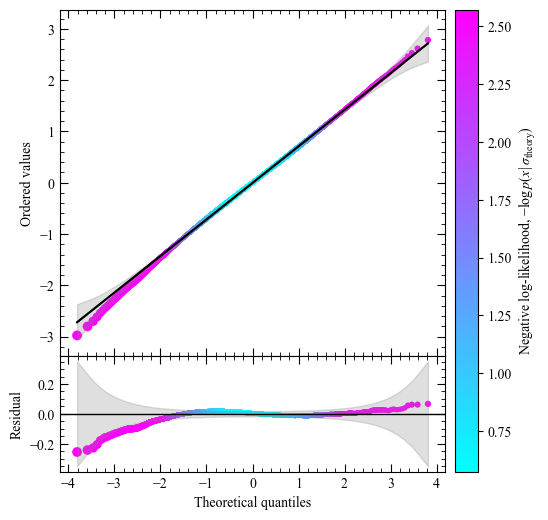

In [60]:
# --- Figure layout ---
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0)

ax_qq = fig.add_subplot(gs[0])
ax_res = fig.add_subplot(gs[1], sharex=ax_qq)

# -------------------
# Top: QQ plot
# -------------------
sc = ax_qq.scatter(  #Data
    osm, osr,
    c=nll,
    norm=norm,
    cmap=cmap_color,
    s=sizes,
    edgecolors='none'
)

ax_qq.plot(  #Black Normal Line
    osm,
    slope * osm + intercept,
    color='black',
    lw=1.2,
    alpha=0.8
)

ax_qq.plot(osm, slope * osm + intercept, color='black', lw=1.5)
ax_qq.fill_between(osm, lower, upper, color='grey', alpha=0.25)

ax_qq.set_ylabel("Ordered values")
ax_qq.minorticks_on()
ax_qq.tick_params(which='major', length=6, direction='in', top=True, right=True)
ax_qq.tick_params(which='minor', length=3, direction='in', top=True, right=True)

plt.setp(ax_qq.get_xticklabels(), visible=False)

# -------------------
# Bottom: detrended QQ
# -------------------
ax_res.scatter(
    osm, qq_res,
    c=nll,
    norm=norm,
    cmap=cmap_color,
    s=sizes,
    edgecolors='none'
)

# ±2σ band
ax_res.axhline(0, color='black', lw=1)

ax_res.set_xlabel("Theoretical quantiles")
ax_res.set_ylabel("Residual")

ax_res.minorticks_on()
ax_res.tick_params(which='major', length=6, direction='in', top=True, right=True)
ax_res.tick_params(which='minor', length=3, direction='in', top=True, right=True)

res_upper = z_alpha * slope * sigma_q
res_lower = -z_alpha * slope * sigma_q

ax_res.fill_between(
    osm,
    res_lower,
    res_upper,
    color='grey',
    alpha=0.25
)

# -------------------
# Colorbar (|z|)
# -------------------
cbar = fig.colorbar(sc, ax=[ax_qq, ax_res], pad=0.02)
cbar.set_label(
    r"Negative log-likelihood, $-\log p(x\,|\,\sigma_{\mathrm{theory}})$"
)

plt.savefig(pc_savepath_qq_metrop, bbox_inches='tight')
plt.show()

# HT for Metropolis

In [51]:
# Known theoretical distribution
mu = 0.0
sigma = 1 / np.sqrt(2)


# Experiment parameters
N_subsample = 10_000
N_repeats = 100

ks_stats = np.empty(N_repeats)
ks_pvals = np.empty(N_repeats)

ad_stats = np.empty(N_repeats)

for i in range(N_repeats):

    # Weighted resampling
    sample = np.random.choice(
        samples_x,
        size=N_subsample,
        replace=True
    )

    # --------------------
    # Fixed-parameter transform
    # --------------------
    z = (sample - mu) / sigma

    # --------------------
    # Kolmogorov–Smirnov
    # --------------------
    ks_res = stats.kstest(
        z,
        'norm',
        method='asymp'
    )

    ks_stats[i] = ks_res.statistic
    ks_pvals[i] = ks_res.pvalue

    # --------------------
    # Anderson–Darling (fixed params)
    # --------------------
    ad_res = stats.anderson(z, dist='norm')
    ad_stats[i] = ad_res.statistic

print("KS statistic:")
print(f"  mean = {ks_stats.mean():.4e}")
print(f"  std  = {ks_stats.std():.4e}")

print("\nKS p-values:")
print(f"  median = {np.median(ks_pvals):.3f}")
print(f"  fraction p < 0.05 = {np.mean(ks_pvals < 0.05):.2f}")

print("\nAD statistic:")
print(f"  mean = {ad_stats.mean():.4f}")
print(f"  std  = {ad_stats.std():.4f}")

KS statistic:
  mean = 1.0538e-02
  std  = 3.1364e-03

KS p-values:
  median = 0.238
  fraction p < 0.05 = 0.17

AD statistic:
  mean = 1.4925
  std  = 0.5889


In [1]:
# Known theoretical distribution
mu = 0.0
sigma = 1 / np.sqrt(2)


# Experiment parameters
N_subsample = 10_000
N_repeats = 100

ks_stats_unopt = np.empty(N_repeats)
ks_pvals_unopt = np.empty(N_repeats)

ad_stats_unopt = np.empty(N_repeats)

for i in range(N_repeats):

    # Weighted resampling
    sample_unopt = np.random.choice(
        samples_x_unopt,
        size=N_subsample,
        replace=True
    )

    # --------------------
    # Fixed-parameter transform
    # --------------------
    z_unopt = (sample_unopt - mu) / sigma

    # --------------------
    # Kolmogorov–Smirnov
    # --------------------
    ks_res_unopt = stats.kstest(
        z_unopt,
        'norm',
        method='asymp'
    )

    ks_stats_unopt[i] = ks_res_unopt.statistic
    ks_pvals_unopt[i] = ks_res_unopt.pvalue

    # --------------------
    # Anderson–Darling (fixed params)
    # --------------------
    ad_res_unopt = stats.anderson(z_unopt, dist='norm')
    ad_stats_unopt[i] = ad_res_unopt.statistic

print("KS statistic:")
print(f"  mean = {ks_stats_unopt.mean():.4e}")
print(f"  std  = {ks_stats_unopt.std():.4e}")

print("\nKS p-values:")
print(f"  median = {np.median(ks_pvals_unopt)}")
print(f"  fraction p < 0.05 = {np.mean(ks_pvals_unopt < 0.05)}")

print("\nAD statistic:")
print(f"  mean = {ad_stats_unopt.mean():.4f}")
print(f"  std  = {ad_stats_unopt.std():.4f}")

NameError: name 'np' is not defined